In [29]:
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
from sklearn.metrics import classification_report
import warnings 
warnings.filterwarnings("ignore")
import seaborn as sns
from sklearn.naive_bayes import GaussianNB, MultinomialNB


In [30]:
import sys
sys.path.append('../src')
from model.proba_model import get_past_meta, predict
from model.evaluation import get_classification_report

In [31]:
import sys
sys.path.append('../src')
from data.data_split import split_data_by_year
from features.contigency_table import create_contigency_table
from model.proba_model import get_past_meta, predict
from model.evaluation import get_classification_report

In [32]:
# ### Definitions
path_data_dir = '../data/'

list_assets = ["PETR3.SA","PRIO3.SA", "VALE3.SA", "GGBR3.SA", "ABCB4.SA", "ITUB3.SA", "FLRY3.SA", "RADL3.SA"]

relevant_cols = ['Date', 'Close', 'Volume']

In [33]:
def get_contigency_table_ind(meta, asset, split):
    
    
    path_data = path_data_dir + f"processed/{split}_contingency_table_ind_price_history_{asset.replace('.', '_')}_meta_-{meta}_dataset_ffill.csv"
    
    cont_tbl = pd.read_csv(path_data, index_col=0)
    
    cont_tbl_probas = cont_tbl.apply(lambda x: [col/sum(x) for col in x])  
    
    return cont_tbl_probas

In [34]:
import pandas as pd

def get_past_meta(
    df,
    row,
    n_past_meta,
    name_meta_col="meta"
):
    idx = row.name
        
    list_past_meta = df.loc[idx-n_past_meta:idx - 1, name_meta_col].to_list()
    
    list_past_meta.reverse()
        
    if idx < n_past_meta:
        # Preencher a lista com valores padrão (None) se o índice for menor que n_past_meta
        return [None] * (n_past_meta - idx) + list_past_meta
    
    return pd.Series([str(i) for i in list_past_meta])




In [35]:
model = MultinomialNB()
from sklearn.preprocessing import MinMaxScaler #fixed import

scaler = MinMaxScaler()


In [36]:
df_results = pd.DataFrame({})

for n_prev_meta in range(1, 6):

    for asset in list_assets:
        
        print(f"""
#######################################
# asset: {asset} - n_prev_meta: {n_prev_meta}
#######################################     
              """)
        
        
        # get train dataset
        train_dataset = pd.read_csv(path_data_dir + f"processed/train_price_history_{asset.replace('.', '_')}_meta_dataset_ffill.csv", index_col= 0).reset_index(drop=True)
        # get test dataset
        test_dataset = pd.read_csv(path_data_dir + f"processed/test_price_history_{asset.replace('.', '_')}_meta_dataset_ffill.csv", index_col= 0).reset_index(drop=True)

        # create features (meta - 1, meta -2, etc)
        train_dataset[[f"Meta - {meta}" for meta in range(1, n_prev_meta + 1)]] = train_dataset.progress_apply(
            lambda x: get_past_meta(train_dataset, x, n_prev_meta, name_meta_col="meta"), axis=1, result_type='expand'
        )        
        test_dataset[[f"Meta - {meta}" for meta in range(1, n_prev_meta + 1)]] = test_dataset.progress_apply(
            lambda x: get_past_meta(test_dataset, x, n_prev_meta, name_meta_col="meta"), axis=1, result_type='expand'
        )
        
        # remove the first rows
        train_dataset = train_dataset.iloc[n_prev_meta:]
        test_dataset = test_dataset.iloc[n_prev_meta:]
        
        # train test split
        X_train = train_dataset[[col for col in train_dataset.columns if 'Meta -' in col]]
        y_train = train_dataset.meta
        X_test = test_dataset[[col for col in test_dataset.columns if 'Meta -' in col]]
        y_test = test_dataset.meta
        
        # scaling (Multinomialnb do not support negative values)
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        # train
        model = MultinomialNB()
        model_trained = model.fit(X_train, y_train)
        
        # predict based on probability table
        y_pred = model_trained.predict(X_test)
        
        # create df with results
        df_results_p = get_classification_report(y_test, y_pred)
        df_results_p['asset'] = asset
        df_results_p['n_prev_meta'] = n_prev_meta
        
        print(classification_report(y_test, y_pred))
        
        df_results = pd.concat([df_results, df_results_p])


#######################################
# asset: PETR3.SA - n_prev_meta: 1
#######################################     
              


  0%|          | 0/3915 [00:00<?, ?it/s]

100%|██████████| 979/979 [00:00<00:00, 3724.31it/s]


              precision    recall  f1-score   support

          -3       0.00      0.00      0.00         3
          -2       0.00      0.00      0.00        32
          -1       0.00      0.00      0.00       175
           0       0.47      1.00      0.64       464
           1       0.00      0.00      0.00       239
           2       0.00      0.00      0.00        62
           3       0.00      0.00      0.00         3

    accuracy                           0.47       978
   macro avg       0.07      0.14      0.09       978
weighted avg       0.23      0.47      0.31       978


#######################################
# asset: PRIO3.SA - n_prev_meta: 1
#######################################     
              


100%|██████████| 979/979 [00:00<00:00, 5074.88it/s]


              precision    recall  f1-score   support

          -2       0.00      0.00      0.00        37
          -1       0.00      0.00      0.00       132
           0       0.47      1.00      0.64       458
           1       0.00      0.00      0.00       274
           2       0.00      0.00      0.00        77

    accuracy                           0.47       978
   macro avg       0.09      0.20      0.13       978
weighted avg       0.22      0.47      0.30       978


#######################################
# asset: VALE3.SA - n_prev_meta: 1
#######################################     
              


100%|██████████| 979/979 [00:00<00:00, 5133.00it/s]


              precision    recall  f1-score   support

          -3       0.00      0.00      0.00         7
          -2       0.00      0.00      0.00        77
          -1       0.00      0.00      0.00       226
           0       0.46      1.00      0.63       445
           1       0.00      0.00      0.00       170
           2       0.00      0.00      0.00        49
           3       0.00      0.00      0.00         4

    accuracy                           0.46       978
   macro avg       0.07      0.14      0.09       978
weighted avg       0.21      0.46      0.28       978


#######################################
# asset: GGBR3.SA - n_prev_meta: 1
#######################################     
              


100%|██████████| 979/979 [00:00<00:00, 5336.08it/s]


              precision    recall  f1-score   support

          -3       0.00      0.00      0.00         7
          -2       0.00      0.00      0.00        59
          -1       0.00      0.00      0.00       179
           0       0.50      1.00      0.66       486
           1       0.00      0.00      0.00       195
           2       0.00      0.00      0.00        49
           3       0.00      0.00      0.00         3

    accuracy                           0.50       978
   macro avg       0.07      0.14      0.09       978
weighted avg       0.25      0.50      0.33       978


#######################################
# asset: ABCB4.SA - n_prev_meta: 1
#######################################     
              


100%|██████████| 979/979 [00:00<00:00, 5053.76it/s]


              precision    recall  f1-score   support

          -2       0.00      0.00      0.00        31
          -1       0.00      0.00      0.00       149
           0       0.50      1.00      0.67       493
           1       0.00      0.00      0.00       233
           2       0.00      0.00      0.00        71
           3       0.00      0.00      0.00         1

    accuracy                           0.50       978
   macro avg       0.08      0.17      0.11       978
weighted avg       0.25      0.50      0.34       978


#######################################
# asset: ITUB3.SA - n_prev_meta: 1
#######################################     
              


100%|██████████| 979/979 [00:00<00:00, 4583.29it/s]


              precision    recall  f1-score   support

          -3       0.00      0.00      0.00         1
          -2       0.00      0.00      0.00        59
          -1       0.00      0.00      0.00       210
           0       0.42      1.00      0.60       415
           1       0.00      0.00      0.00       236
           2       0.00      0.00      0.00        55
           3       0.00      0.00      0.00         2

    accuracy                           0.42       978
   macro avg       0.06      0.14      0.09       978
weighted avg       0.18      0.42      0.25       978


#######################################
# asset: FLRY3.SA - n_prev_meta: 1
#######################################     
              


100%|██████████| 979/979 [00:00<00:00, 3652.57it/s]


              precision    recall  f1-score   support

          -2       0.00      0.00      0.00        60
          -1       0.00      0.00      0.00       263
           0       0.46      1.00      0.63       454
           1       0.00      0.00      0.00       168
           2       0.00      0.00      0.00        30
           3       0.00      0.00      0.00         3

    accuracy                           0.46       978
   macro avg       0.08      0.17      0.11       978
weighted avg       0.22      0.46      0.29       978


#######################################
# asset: RADL3.SA - n_prev_meta: 1
#######################################     
              


100%|██████████| 979/979 [00:00<00:00, 4572.73it/s]


              precision    recall  f1-score   support

          -2       0.00      0.00      0.00        50
          -1       0.00      0.00      0.00       180
           0       0.46      1.00      0.63       453
           1       0.00      0.00      0.00       263
           2       0.00      0.00      0.00        30
           3       0.00      0.00      0.00         2

    accuracy                           0.46       978
   macro avg       0.08      0.17      0.11       978
weighted avg       0.21      0.46      0.29       978


#######################################
# asset: PETR3.SA - n_prev_meta: 2
#######################################     
              


100%|██████████| 979/979 [00:00<00:00, 4897.23it/s]


              precision    recall  f1-score   support

          -3       0.00      0.00      0.00         3
          -2       0.00      0.00      0.00        32
          -1       0.00      0.00      0.00       175
           0       0.47      1.00      0.64       464
           1       0.00      0.00      0.00       238
           2       0.00      0.00      0.00        62
           3       0.00      0.00      0.00         3

    accuracy                           0.47       977
   macro avg       0.07      0.14      0.09       977
weighted avg       0.23      0.47      0.31       977


#######################################
# asset: PRIO3.SA - n_prev_meta: 2
#######################################     
              


100%|██████████| 979/979 [00:00<00:00, 4840.33it/s]


              precision    recall  f1-score   support

          -2       0.00      0.00      0.00        37
          -1       0.00      0.00      0.00       131
           0       0.47      1.00      0.64       458
           1       0.00      0.00      0.00       274
           2       0.00      0.00      0.00        77

    accuracy                           0.47       977
   macro avg       0.09      0.20      0.13       977
weighted avg       0.22      0.47      0.30       977


#######################################
# asset: VALE3.SA - n_prev_meta: 2
#######################################     
              


100%|██████████| 979/979 [00:00<00:00, 5583.31it/s]


              precision    recall  f1-score   support

          -3       0.00      0.00      0.00         7
          -2       0.00      0.00      0.00        77
          -1       0.00      0.00      0.00       225
           0       0.46      1.00      0.63       445
           1       0.00      0.00      0.00       170
           2       0.00      0.00      0.00        49
           3       0.00      0.00      0.00         4

    accuracy                           0.46       977
   macro avg       0.07      0.14      0.09       977
weighted avg       0.21      0.46      0.29       977


#######################################
# asset: GGBR3.SA - n_prev_meta: 2
#######################################     
              


100%|██████████| 979/979 [00:00<00:00, 4669.06it/s]


              precision    recall  f1-score   support

          -3       0.00      0.00      0.00         7
          -2       0.00      0.00      0.00        59
          -1       0.00      0.00      0.00       179
           0       0.50      1.00      0.66       485
           1       0.00      0.00      0.00       195
           2       0.00      0.00      0.00        49
           3       0.00      0.00      0.00         3

    accuracy                           0.50       977
   macro avg       0.07      0.14      0.09       977
weighted avg       0.25      0.50      0.33       977


#######################################
# asset: ABCB4.SA - n_prev_meta: 2
#######################################     
              


100%|██████████| 979/979 [00:00<00:00, 3275.85it/s]


              precision    recall  f1-score   support

          -2       0.00      0.00      0.00        31
          -1       0.00      0.00      0.00       149
           0       0.50      1.00      0.67       493
           1       0.00      0.00      0.00       232
           2       0.00      0.00      0.00        71
           3       0.00      0.00      0.00         1

    accuracy                           0.50       977
   macro avg       0.08      0.17      0.11       977
weighted avg       0.25      0.50      0.34       977


#######################################
# asset: ITUB3.SA - n_prev_meta: 2
#######################################     
              


100%|██████████| 979/979 [00:00<00:00, 3813.73it/s]


              precision    recall  f1-score   support

          -3       0.00      0.00      0.00         1
          -2       0.00      0.00      0.00        59
          -1       0.00      0.00      0.00       210
           0       0.42      1.00      0.60       414
           1       0.00      0.00      0.00       236
           2       0.00      0.00      0.00        55
           3       0.00      0.00      0.00         2

    accuracy                           0.42       977
   macro avg       0.06      0.14      0.09       977
weighted avg       0.18      0.42      0.25       977


#######################################
# asset: FLRY3.SA - n_prev_meta: 2
#######################################     
              


100%|██████████| 979/979 [00:00<00:00, 4846.50it/s]


              precision    recall  f1-score   support

          -2       0.00      0.00      0.00        60
          -1       0.00      0.00      0.00       263
           0       0.46      1.00      0.63       453
           1       0.00      0.00      0.00       168
           2       0.00      0.00      0.00        30
           3       0.00      0.00      0.00         3

    accuracy                           0.46       977
   macro avg       0.08      0.17      0.11       977
weighted avg       0.21      0.46      0.29       977


#######################################
# asset: RADL3.SA - n_prev_meta: 2
#######################################     
              


100%|██████████| 979/979 [00:00<00:00, 4843.52it/s]


              precision    recall  f1-score   support

          -2       0.00      0.00      0.00        50
          -1       0.00      0.00      0.00       180
           0       0.46      1.00      0.63       452
           1       0.00      0.00      0.00       263
           2       0.00      0.00      0.00        30
           3       0.00      0.00      0.00         2

    accuracy                           0.46       977
   macro avg       0.08      0.17      0.11       977
weighted avg       0.21      0.46      0.29       977


#######################################
# asset: PETR3.SA - n_prev_meta: 3
#######################################     
              


100%|██████████| 979/979 [00:00<00:00, 4366.80it/s]


              precision    recall  f1-score   support

          -3       0.00      0.00      0.00         3
          -2       0.00      0.00      0.00        32
          -1       0.00      0.00      0.00       175
           0       0.48      1.00      0.64       464
           1       0.00      0.00      0.00       237
           2       0.00      0.00      0.00        62
           3       0.00      0.00      0.00         3

    accuracy                           0.48       976
   macro avg       0.07      0.14      0.09       976
weighted avg       0.23      0.48      0.31       976


#######################################
# asset: PRIO3.SA - n_prev_meta: 3
#######################################     
              


100%|██████████| 979/979 [00:00<00:00, 5101.10it/s]


              precision    recall  f1-score   support

          -2       0.00      0.00      0.00        37
          -1       0.00      0.00      0.00       130
           0       0.47      1.00      0.64       458
           1       0.00      0.00      0.00       274
           2       0.00      0.00      0.00        77

    accuracy                           0.47       976
   macro avg       0.09      0.20      0.13       976
weighted avg       0.22      0.47      0.30       976


#######################################
# asset: VALE3.SA - n_prev_meta: 3
#######################################     
              


100%|██████████| 979/979 [00:00<00:00, 3189.90it/s]


              precision    recall  f1-score   support

          -3       0.00      0.00      0.00         7
          -2       0.00      0.00      0.00        77
          -1       0.00      0.00      0.00       224
           0       0.46      1.00      0.63       445
           1       0.00      0.00      0.00       170
           2       0.00      0.00      0.00        49
           3       0.00      0.00      0.00         4

    accuracy                           0.46       976
   macro avg       0.07      0.14      0.09       976
weighted avg       0.21      0.46      0.29       976


#######################################
# asset: GGBR3.SA - n_prev_meta: 3
#######################################     
              


100%|██████████| 979/979 [00:00<00:00, 3564.12it/s]


              precision    recall  f1-score   support

          -3       0.00      0.00      0.00         7
          -2       0.00      0.00      0.00        59
          -1       0.00      0.00      0.00       179
           0       0.50      1.00      0.66       484
           1       0.00      0.00      0.00       195
           2       0.00      0.00      0.00        49
           3       0.00      0.00      0.00         3

    accuracy                           0.50       976
   macro avg       0.07      0.14      0.09       976
weighted avg       0.25      0.50      0.33       976


#######################################
# asset: ABCB4.SA - n_prev_meta: 3
#######################################     
              


100%|██████████| 979/979 [00:00<00:00, 4849.81it/s]


              precision    recall  f1-score   support

          -2       0.00      0.00      0.00        31
          -1       0.00      0.00      0.00       149
           0       0.51      1.00      0.67       493
           1       0.00      0.00      0.00       231
           2       0.00      0.00      0.00        71
           3       0.00      0.00      0.00         1

    accuracy                           0.51       976
   macro avg       0.08      0.17      0.11       976
weighted avg       0.26      0.51      0.34       976


#######################################
# asset: ITUB3.SA - n_prev_meta: 3
#######################################     
              


100%|██████████| 979/979 [00:00<00:00, 5229.81it/s]


              precision    recall  f1-score   support

          -3       0.00      0.00      0.00         1
          -2       0.00      0.00      0.00        59
          -1       0.00      0.00      0.00       210
           0       0.42      1.00      0.59       413
           1       0.00      0.00      0.00       236
           2       0.00      0.00      0.00        55
           3       0.00      0.00      0.00         2

    accuracy                           0.42       976
   macro avg       0.06      0.14      0.08       976
weighted avg       0.18      0.42      0.25       976


#######################################
# asset: FLRY3.SA - n_prev_meta: 3
#######################################     
              


100%|██████████| 979/979 [00:00<00:00, 4851.27it/s]


              precision    recall  f1-score   support

          -2       0.00      0.00      0.00        60
          -1       0.00      0.00      0.00       263
           0       0.46      1.00      0.63       452
           1       0.00      0.00      0.00       168
           2       0.00      0.00      0.00        30
           3       0.00      0.00      0.00         3

    accuracy                           0.46       976
   macro avg       0.08      0.17      0.11       976
weighted avg       0.21      0.46      0.29       976


#######################################
# asset: RADL3.SA - n_prev_meta: 3
#######################################     
              


100%|██████████| 979/979 [00:00<00:00, 4240.31it/s]


              precision    recall  f1-score   support

          -2       0.00      0.00      0.00        50
          -1       0.00      0.00      0.00       180
           0       0.46      1.00      0.63       451
           1       0.00      0.00      0.00       263
           2       0.00      0.00      0.00        30
           3       0.00      0.00      0.00         2

    accuracy                           0.46       976
   macro avg       0.08      0.17      0.11       976
weighted avg       0.21      0.46      0.29       976


#######################################
# asset: PETR3.SA - n_prev_meta: 4
#######################################     
              


100%|██████████| 979/979 [00:00<00:00, 3804.30it/s]


              precision    recall  f1-score   support

          -3       0.00      0.00      0.00         3
          -2       0.00      0.00      0.00        32
          -1       0.00      0.00      0.00       175
           0       0.48      1.00      0.64       464
           1       0.00      0.00      0.00       236
           2       0.00      0.00      0.00        62
           3       0.00      0.00      0.00         3

    accuracy                           0.48       975
   macro avg       0.07      0.14      0.09       975
weighted avg       0.23      0.48      0.31       975


#######################################
# asset: PRIO3.SA - n_prev_meta: 4
#######################################     
              


100%|██████████| 979/979 [00:00<00:00, 3679.74it/s]


              precision    recall  f1-score   support

          -2       0.00      0.00      0.00        37
          -1       0.00      0.00      0.00       129
           0       0.47      1.00      0.64       458
           1       0.00      0.00      0.00       274
           2       0.00      0.00      0.00        77

    accuracy                           0.47       975
   macro avg       0.09      0.20      0.13       975
weighted avg       0.22      0.47      0.30       975


#######################################
# asset: VALE3.SA - n_prev_meta: 4
#######################################     
              


100%|██████████| 979/979 [00:00<00:00, 4368.79it/s]


              precision    recall  f1-score   support

          -3       0.00      0.00      0.00         7
          -2       0.00      0.00      0.00        77
          -1       0.00      0.00      0.00       223
           0       0.46      1.00      0.63       445
           1       0.00      0.00      0.00       170
           2       0.00      0.00      0.00        49
           3       0.00      0.00      0.00         4

    accuracy                           0.46       975
   macro avg       0.07      0.14      0.09       975
weighted avg       0.21      0.46      0.29       975


#######################################
# asset: GGBR3.SA - n_prev_meta: 4
#######################################     
              


100%|██████████| 979/979 [00:00<00:00, 4680.23it/s]


              precision    recall  f1-score   support

          -3       0.00      0.00      0.00         7
          -2       0.00      0.00      0.00        58
          -1       0.00      0.00      0.00       179
           0       0.50      1.00      0.66       484
           1       0.00      0.00      0.00       195
           2       0.00      0.00      0.00        49
           3       0.00      0.00      0.00         3

    accuracy                           0.50       975
   macro avg       0.07      0.14      0.09       975
weighted avg       0.25      0.50      0.33       975


#######################################
# asset: ABCB4.SA - n_prev_meta: 4
#######################################     
              


100%|██████████| 979/979 [00:00<00:00, 5040.19it/s]


              precision    recall  f1-score   support

          -2       0.00      0.00      0.00        31
          -1       0.00      0.00      0.00       149
           0       0.50      1.00      0.67       492
           1       0.00      0.00      0.00       231
           2       0.00      0.00      0.00        71
           3       0.00      0.00      0.00         1

    accuracy                           0.50       975
   macro avg       0.08      0.17      0.11       975
weighted avg       0.25      0.50      0.34       975


#######################################
# asset: ITUB3.SA - n_prev_meta: 4
#######################################     
              


100%|██████████| 979/979 [00:00<00:00, 4948.73it/s]


              precision    recall  f1-score   support

          -3       0.00      0.00      0.00         1
          -2       0.00      0.00      0.00        59
          -1       0.00      0.00      0.00       210
           0       0.42      1.00      0.59       412
           1       0.00      0.00      0.00       236
           2       0.00      0.00      0.00        55
           3       0.00      0.00      0.00         2

    accuracy                           0.42       975
   macro avg       0.06      0.14      0.08       975
weighted avg       0.18      0.42      0.25       975


#######################################
# asset: FLRY3.SA - n_prev_meta: 4
#######################################     
              


100%|██████████| 979/979 [00:00<00:00, 4763.59it/s]


              precision    recall  f1-score   support

          -2       0.00      0.00      0.00        60
          -1       0.00      0.00      0.00       263
           0       0.46      1.00      0.63       451
           1       0.00      0.00      0.00       168
           2       0.00      0.00      0.00        30
           3       0.00      0.00      0.00         3

    accuracy                           0.46       975
   macro avg       0.08      0.17      0.11       975
weighted avg       0.21      0.46      0.29       975


#######################################
# asset: RADL3.SA - n_prev_meta: 4
#######################################     
              


100%|██████████| 979/979 [00:00<00:00, 3325.09it/s]


              precision    recall  f1-score   support

          -2       0.00      0.00      0.00        50
          -1       0.00      0.00      0.00       180
           0       0.46      1.00      0.63       450
           1       0.00      0.00      0.00       263
           2       0.00      0.00      0.00        30
           3       0.00      0.00      0.00         2

    accuracy                           0.46       975
   macro avg       0.08      0.17      0.11       975
weighted avg       0.21      0.46      0.29       975


#######################################
# asset: PETR3.SA - n_prev_meta: 5
#######################################     
              


100%|██████████| 979/979 [00:00<00:00, 5107.80it/s]


              precision    recall  f1-score   support

          -3       0.00      0.00      0.00         3
          -2       0.00      0.00      0.00        32
          -1       0.00      0.00      0.00       175
           0       0.48      1.00      0.64       463
           1       0.00      0.00      0.00       236
           2       0.00      0.00      0.00        62
           3       0.00      0.00      0.00         3

    accuracy                           0.48       974
   macro avg       0.07      0.14      0.09       974
weighted avg       0.23      0.48      0.31       974


#######################################
# asset: PRIO3.SA - n_prev_meta: 5
#######################################     
              


100%|██████████| 979/979 [00:00<00:00, 4914.38it/s]


              precision    recall  f1-score   support

          -2       0.00      0.00      0.00        37
          -1       0.00      0.00      0.00       128
           0       0.47      1.00      0.64       458
           1       0.00      0.00      0.00       274
           2       0.00      0.00      0.00        77

    accuracy                           0.47       974
   macro avg       0.09      0.20      0.13       974
weighted avg       0.22      0.47      0.30       974


#######################################
# asset: VALE3.SA - n_prev_meta: 5
#######################################     
              


100%|██████████| 979/979 [00:00<00:00, 4923.41it/s]


              precision    recall  f1-score   support

          -3       0.00      0.00      0.00         7
          -2       0.00      0.00      0.00        77
          -1       0.00      0.00      0.00       222
           0       0.46      1.00      0.63       445
           1       0.00      0.00      0.00       170
           2       0.00      0.00      0.00        49
           3       0.00      0.00      0.00         4

    accuracy                           0.46       974
   macro avg       0.07      0.14      0.09       974
weighted avg       0.21      0.46      0.29       974


#######################################
# asset: GGBR3.SA - n_prev_meta: 5
#######################################     
              


100%|██████████| 979/979 [00:00<00:00, 4131.76it/s]


              precision    recall  f1-score   support

          -3       0.00      0.00      0.00         6
          -2       0.00      0.00      0.00        58
          -1       0.00      0.00      0.00       179
           0       0.50      1.00      0.66       484
           1       0.00      0.00      0.00       195
           2       0.00      0.00      0.00        49
           3       0.00      0.00      0.00         3

    accuracy                           0.50       974
   macro avg       0.07      0.14      0.09       974
weighted avg       0.25      0.50      0.33       974


#######################################
# asset: ABCB4.SA - n_prev_meta: 5
#######################################     
              


100%|██████████| 979/979 [00:00<00:00, 4660.67it/s]


              precision    recall  f1-score   support

          -2       0.00      0.00      0.00        31
          -1       0.00      0.00      0.00       148
           0       0.51      1.00      0.67       492
           1       0.00      0.00      0.00       231
           2       0.00      0.00      0.00        71
           3       0.00      0.00      0.00         1

    accuracy                           0.51       974
   macro avg       0.08      0.17      0.11       974
weighted avg       0.26      0.51      0.34       974


#######################################
# asset: ITUB3.SA - n_prev_meta: 5
#######################################     
              


100%|██████████| 979/979 [00:00<00:00, 3598.89it/s]


              precision    recall  f1-score   support

          -3       0.00      0.00      0.00         1
          -2       0.00      0.00      0.00        59
          -1       0.00      0.00      0.00       210
           0       0.42      1.00      0.59       411
           1       0.00      0.00      0.00       236
           2       0.00      0.00      0.00        55
           3       0.00      0.00      0.00         2

    accuracy                           0.42       974
   macro avg       0.06      0.14      0.08       974
weighted avg       0.18      0.42      0.25       974


#######################################
# asset: FLRY3.SA - n_prev_meta: 5
#######################################     
              


100%|██████████| 979/979 [00:00<00:00, 4655.34it/s]


              precision    recall  f1-score   support

          -2       0.00      0.00      0.00        60
          -1       0.00      0.00      0.00       262
           0       0.46      1.00      0.63       451
           1       0.00      0.00      0.00       168
           2       0.00      0.00      0.00        30
           3       0.00      0.00      0.00         3

    accuracy                           0.46       974
   macro avg       0.08      0.17      0.11       974
weighted avg       0.21      0.46      0.29       974


#######################################
# asset: RADL3.SA - n_prev_meta: 5
#######################################     
              


100%|██████████| 979/979 [00:00<00:00, 4819.47it/s]

              precision    recall  f1-score   support

          -2       0.00      0.00      0.00        50
          -1       0.00      0.00      0.00       179
           0       0.46      1.00      0.63       450
           1       0.00      0.00      0.00       263
           2       0.00      0.00      0.00        30
           3       0.00      0.00      0.00         2

    accuracy                           0.46       974
   macro avg       0.08      0.17      0.11       974
weighted avg       0.21      0.46      0.29       974



In [37]:
df_results

,precision,recall,f1-score,support,asset,n_prev_meta
0,0.474438,1.000000,0.643551,464.000000,PETR3.SA,1
accuracy,0.474438,0.474438,0.474438,0.474438,PETR3.SA,1
weighted avg,0.225091,0.474438,0.305325,978.000000,PETR3.SA,1
macro avg,0.067777,0.142857,0.091936,978.000000,PETR3.SA,1
-3,0.000000,0.000000,0.000000,3.000000,PETR3.SA,1
...,...,...,...,...,...,...
-2,0.000000,0.000000,0.000000,50.000000,RADL3.SA,5
-1,0.000000,0.000000,0.000000,179.000000,RADL3.SA,5
1,0.000000,0.000000,0.000000,263.000000,RADL3.SA,5
2,0.000000,0.000000,0.000000,30.000000,RADL3.SA,5


In [38]:
test_dataset

,Date,Close,Volume,SMA_21,MSTD_21,Day_of_week,Weekend,Invalid_Days,diff_close_mean,diff_close_mean_z_score,meta,Meta - 1,Meta - 2,Meta - 3,Meta - 4,Meta - 5
5,2021-08-18,24.326923,5589168.0,24.930861,0.480737,2,0,0,-0.603937,-1.256275,-1,-1,0,0,0,0
6,2021-08-19,25.211538,5636176.0,24.911630,0.459597,3,0,0,0.299909,0.652546,0,-1,-1,0,0,0
7,2021-08-20,25.644230,6478888.0,24.903846,0.444809,4,0,0,0.740384,1.664499,1,0,-1,-1,0,0
8,2021-08-21,25.644230,6478888.0,24.903846,0.444809,5,1,1,0.740384,1.664499,1,1,0,-1,-1,0
9,2021-08-22,25.644230,6478888.0,24.903846,0.444809,6,1,1,0.740384,1.664499,1,1,1,0,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
974,2024-04-13,26.360001,6572900.0,26.945714,0.559612,5,1,1,-0.585714,-1.046642,-1,-1,-1,-1,0,0
975,2024-04-14,26.360001,6572900.0,26.945714,0.559612,6,1,1,-0.585714,-1.046642,-1,-1,-1,-1,-1,0
976,2024-04-15,26.200001,6162400.0,26.910000,0.582778,0,0,0,-0.709999,-1.218302,-1,-1,-1,-1,-1,-1
977,2024-04-16,25.219999,7498900.0,26.825238,0.688830,1,0,0,-1.605239,-2.330385,-2,-1,-1,-1,-1,-1


In [39]:
df_results= df_results.reset_index().rename({'index': 'class'}, axis = 1)
df_results

,class,precision,recall,f1-score,support,asset,n_prev_meta
0,0,0.474438,1.000000,0.643551,464.000000,PETR3.SA,1
1,accuracy,0.474438,0.474438,0.474438,0.474438,PETR3.SA,1
2,weighted avg,0.225091,0.474438,0.305325,978.000000,PETR3.SA,1
3,macro avg,0.067777,0.142857,0.091936,978.000000,PETR3.SA,1
4,-3,0.000000,0.000000,0.000000,3.000000,PETR3.SA,1
...,...,...,...,...,...,...,...
370,-2,0.000000,0.000000,0.000000,50.000000,RADL3.SA,5
371,-1,0.000000,0.000000,0.000000,179.000000,RADL3.SA,5
372,1,0.000000,0.000000,0.000000,263.000000,RADL3.SA,5
373,2,0.000000,0.000000,0.000000,30.000000,RADL3.SA,5


In [40]:
df_f1_macro = df_results[
    (df_results['class'] == 'macro avg')]
[['f1-score', 'asset' ,'n_prev_meta']]
df_f1_macro

,class,precision,recall,f1-score,support,asset,n_prev_meta
3,macro avg,0.067777,0.142857,0.091936,978.0,PETR3.SA,1
13,macro avg,0.093661,0.200000,0.127577,978.0,PRIO3.SA,1
21,macro avg,0.065001,0.142857,0.089348,978.0,VALE3.SA,1
31,macro avg,0.070990,0.142857,0.094848,978.0,GGBR3.SA,1
41,macro avg,0.084015,0.166667,0.111715,978.0,ABCB4.SA,1
50,macro avg,0.060619,0.142857,0.085119,978.0,ITUB3.SA,1
60,macro avg,0.077369,0.166667,0.105680,978.0,FLRY3.SA,1
69,macro avg,0.077198,0.166667,0.105521,978.0,RADL3.SA,1
78,macro avg,0.067846,0.142857,0.092000,977.0,PETR3.SA,2
88,macro avg,0.093756,0.200000,0.127666,977.0,PRIO3.SA,2


<Axes: xlabel='n_prev_meta', ylabel='f1-score'>

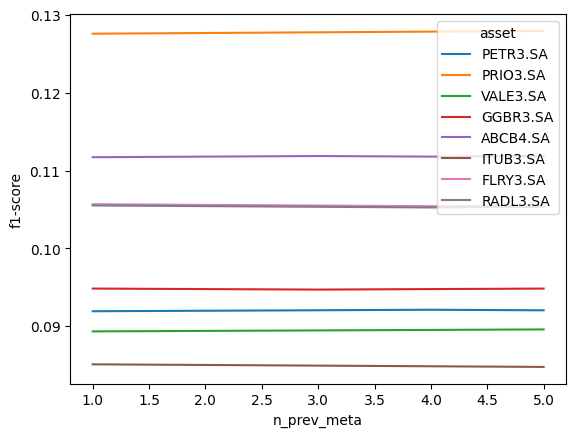

In [41]:
sns.lineplot(data=df_f1_macro, x="n_prev_meta", y="f1-score", hue="asset")